In [1]:
import pandas as pd
from typing import List
import numpy as np
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer #Three stemmers for data simplification
from nltk.tokenize import sent_tokenize, word_tokenize # Tokenizers for data cleaning
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import matplotlib.pyplot as plt
stop_words = set(stopwords.words('english'))
%matplotlib inline

In [2]:
! ls

Axios_coding.ipynb   nytimes articles.csv


In [3]:
df = pd.read_csv('nytimes articles.csv')

In [4]:
def remove_stopwords(strTokens, stopWords=stop_words):
    if strTokens is not None:
        return [j.strip().lower() for j in strTokens if j.strip().lower() not in stopWords and re.match('^[A-Za-z]*$',j)]
    return strTokens

def tokenize(strToken):
    if strToken == strToken:
        return [word for sent in sent_tokenize(strToken) for word in word_tokenize(sent)]
    return []

def stemmer(tokens:List[str], stemmerFxn):
    return [stemmerFxn.stem(j) for j in tokens]

def getAuthors(authString, regFilter=r"\sand\s|,\s"):
    if authString == authString:
        return [j for j in re.split(regFilter, authString) if len(j) > 0]
    return []

def tokenizeThenStemm(strToken, stopWords=stop_words, stemmerFxn=SnowballStemmer('english')):
    if strToken == strToken:
        return stemmer(remove_stopwords(tokenize(strToken), stopWords=stop_words), stemmerFxn)
    return []
#sns = SnowballStemmer('english')
#output = [sns.stem(j) for j in word_tokenize(smple)]

In [5]:
# output


### first we look at the stemmedTitle and stemmedContent to get word frequency information

In [20]:
stemmedTitleContent = (df.title + " " + df.content).apply(lambda x: tokenizeThenStemm(x, stopWords=stop_words, stemmerFxn=SnowballStemmer('english')))

In [21]:
word_counts = stemmedTitleContent.apply(pd.Series).stack().reset_index(drop=True)
value_counts = word_counts.value_counts()

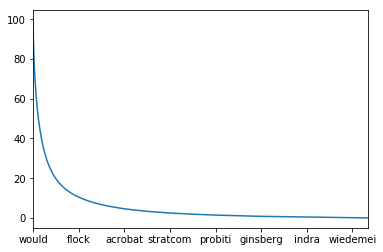

In [22]:
wordProb = 100*(value_counts/value_counts.sum())
(100-wordProb.cumsum()).plot()

### Removing the following words as they occur at the highest rate. 

If this were more rigorous, this would be statistically calculated. We will also only take the top 80% of words

In [ ]:
stop_words.add('said')
stop_words.add('trump')

In [ ]:
trainingData = df.copy()
trainingData['authors'] = trainingData.author.apply(lambda x: getAuthors(x))
trainingData['titleToken'] = trainingData.title.apply(lambda x: remove_stopwords(tokenize(x)))
trainingData['contentToken'] = trainingData.content.apply(lambda x: remove_stopwords(tokenize(x)))

## For the training we will be using TF-IDF with ngrams

This gives a sense of the word frequency while preserving the document information into the training matrix. As we have a small corpus, we will be using 1-3 ngrams and using the top 80% of probable words 

In [ ]:
# tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizeThenStemm)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), tokenizer=tokenizeThenStemm,max_features=wordProb.cumsum()[wordProb.cumsum() < 80.].shape[0])
contentFeatures = tfidf_vectorizer.fit_transform(trainingData[trainingData.content.notna()].content)

## Training

### Kmeans clustering

A simple clustering algorithm that can be learned is the K-Means clustering. This is a distance-measure clustering algorithm. As we would expect articles that have similar themes to have similar features, this is a good place to start

In [11]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans #we will be using MiniBatchKMeans because of time constraints
from scipy.spatial.distance import cdist

### Determining the number of clusters to use

In this case we will be using the elbow method. This requires us to train a model for each of the cluters we are interested in, here 1-20

In [12]:
kmeansModels = []
distortions = []
for num_clusters in range(1,21):
    print(num_clusters)
    KM = MiniBatchKMeans(n_clusters=num_clusters)
    KM.fit(contentFeatures)
    #trainingData[f'km_{num_clusters}'] = KM.labels_.tolist()
    kmeansModels.append(KM)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


### Elbow method

Generally we would like to see an elbow in the plot in some way, or a discontinuity in the 'inertia' of the cluster models. It appears that a smal elbow happesn at 12 clusters, though more time should be spend making sure the feature space is reprecentative of the training.

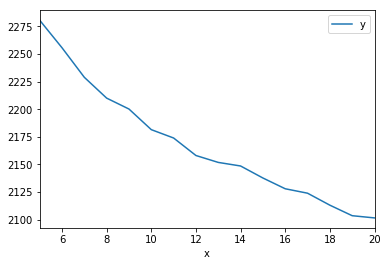

In [14]:
elbow_plot = [{'x':i[0],'y':i[1].inertia_} for i in zip(range(5,21),kmeansModels)]
pd.DataFrame(elbow_plot).plot(x='x',y='y')

### Determinging cluster counts and names

Here we manually select 12 clusters (12 - 1 in the list), and calculate their id followed by their cluster "name" determined by the highest 3 words in the cluster

In [15]:
predictData = trainingData[trainingData.content.notna()].copy()
predictData['km'] = kmeansModels[11].labels_
predictData['km'].value_counts()

1     703
8     471
3     386
10    290
6     173
11    115
5      96
7      76
0      62
9      46
2      44
4      25
Name: km, dtype: int64

In [18]:
cluster_names = {}
for i in predictData['km'].value_counts().index:
    clusters_ = predictData[predictData.km == i].titleToken.apply(pd.Series).stack().reset_index(drop=True).value_counts().index
    cluster_names[i] = tuple(clusters_[j] for j in range(0,3))

In [19]:
cluster_names

{1: ('trump', 'new', 'california'),
 8: ('trump', 'briefing', 'evening'),
 3: ('trump', 'new', 'women'),
 10: ('new', 'dies', 'review'),
 6: ('trump', 'health', 'gorsuch'),
 11: ('syria', 'trump', 'attack'),
 5: ('trump', 'russia', 'russian'),
 7: ('china', 'trump', 'briefing'),
 0: ('israel', 'trump', 'prison'),
 9: ('police', 'new', 'attack'),
 2: ('korea', 'north', 'south'),
 4: ('brexit', 'may', 'independence')}

## Hierarchacle clustering

In [612]:
from sklearn.cluster import AgglomerativeClustering

In [613]:
aggModel = AgglomerativeClustering(n_clusters=14)
aggModel.fit(contentFeatures.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=14,
            pooling_func='deprecated')

In [614]:
predictData['ag'] = aggModel.labels_

In [615]:
predictData.ag.value_counts()

5     437
1     373
2     339
3     302
6     184
13    170
4     148
0     135
10    124
7      72
9      69
8      60
11     41
12     33
Name: ag, dtype: int64

In [616]:
cluster_names = {}
for i in predictData['ag'].value_counts().index:
    cluster_names[i] = predictData[predictData.km == i].titleToken.apply(pd.Series).stack().reset_index(drop=True).value_counts().index[1]

In [617]:
cluster_names

{5: 'north',
 1: 'briefing',
 2: 'new',
 3: 'review',
 6: 'men',
 13: 'attack',
 4: 'ban',
 0: 'senate',
 10: 'trump',
 7: 'trump',
 9: 'trump',
 8: 'carolina',
 11: 'trump',
 12: 'court'}

In [560]:
# Merging Title to Article

In [621]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.05,ngram_range=(1,3), tokenizer=tokenizeThenStemm, max_features=300)
title_content = trainingData.title + trainingData.content
contentFeatures = tfidf_vectorizer.fit_transform(title_content[title_content.notna()])

In [622]:
tfidf_vectorizer.get_feature_names()

['accord',
 'act',
 'ad',
 'administr',
 'advis',
 'agenc',
 'ago',
 'allow',
 'alreadi',
 'also',
 'america',
 'american',
 'among',
 'announc',
 'anoth',
 'appear',
 'around',
 'ask',
 'attack',
 'author',
 'away',
 'back',
 'becom',
 'began',
 'believ',
 'best',
 'big',
 'bill',
 'black',
 'book',
 'brief',
 'build',
 'busi',
 'call',
 'came',
 'campaign',
 'care',
 'case',
 'center',
 'chang',
 'charg',
 'chief',
 'children',
 'china',
 'citi',
 'clear',
 'close',
 'come',
 'committe',
 'compani',
 'concern',
 'conserv',
 'continu',
 'could',
 'countri',
 'court',
 'creat',
 'critic',
 'day',
 'deal',
 'decis',
 'democrat',
 'depart',
 'develop',
 'differ',
 'direct',
 'director',
 'earli',
 'effort',
 'elect',
 'end',
 'even',
 'everi',
 'execut',
 'expect',
 'face',
 'famili',
 'far',
 'feder',
 'feel',
 'find',
 'first',
 'follow',
 'forc',
 'foreign',
 'former',
 'found',
 'four',
 'friday',
 'friend',
 'game',
 'general',
 'get',
 'give',
 'go',
 'good',
 'govern',
 'great',
 

In [623]:
kmeansModels = []
distortions = []
for num_clusters in range(1,21):
    print(num_clusters)
    KM = MiniBatchKMeans(n_clusters=num_clusters)
    KM.fit(contentFeatures)
    #trainingData[f'km_{num_clusters}'] = KM.labels_.tolist()
    kmeansModels.append(KM)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


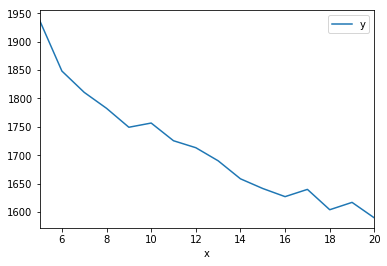

In [624]:
elbow_plot = [{'x':i[0],'y':i[1].inertia_} for i in zip(range(5,21),kmeansModels)]
pd.DataFrame(elbow_plot).plot(x='x',y='y')

In [631]:
predictData = trainingData[trainingData.content.notna()].copy()
predictData['km_t_c'] = kmeansModels[15].labels_
predictData['km_t_c'].value_counts()

14    388
3     311
10    302
15    233
6     191
4     186
8     149
2     138
7     102
13     96
1      85
0      79
9      70
5      59
11     49
12     49
Name: km_t_c, dtype: int64

In [632]:
cluster_names = {}
for i in predictData['km_t_c'].value_counts().index:
    keys = predictData[predictData.km_t_c == i].titleToken.apply(pd.Series).stack().reset_index(drop=True).value_counts().index
    cluster_names[i] = ' '.join([keys[jj] for jj in range(0,3)])
cluster_names

{14: 'new dies women',
 3: 'trump new uber',
 10: 'review trump new',
 15: 'trump donald news',
 6: 'police russia attack',
 4: 'trump ban immigration',
 8: 'trump house white',
 2: 'trump health republicans',
 7: 'california today briefing',
 13: 'women carolina team',
 1: 'city new york',
 0: 'court trump gorsuch',
 9: 'china trump korea',
 5: 'school education student',
 11: 'trump fed rate',
 12: 'briefing evening trump'}

In [627]:
from sklearn.manifold import TSNE

In [633]:
X_embedded = TSNE(n_components=2).fit_transform(contentFeatures.toarray())

In [634]:
predictData['X'] = X_embedded[:,0]
predictData['Y'] = X_embedded[:,1]

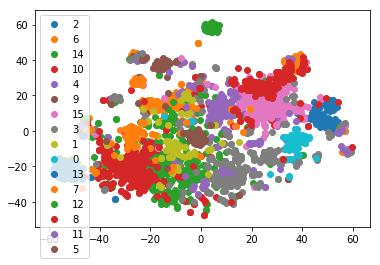

In [635]:
for i in predictData.km_t_c.unique():
    plt_data = predictData[predictData.km_t_c == i]
    plt.scatter(plt_data.X, plt_data.Y, label=i)
    
plt.legend()

In [ ]:
uniqueAuthors = trainingData.authors.apply(pd.Series).stack().reset_index(drop=True).value_counts()